# fMRI_Delay
## Notebook for experimentation on Results Validation

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy import stats, sparse
from itertools import combinations, permutations

import pickle

import fmri_delay

## Shuffling of innovations

Definition of the method to generate random signals where voxel assignments of each innovation are randomized.

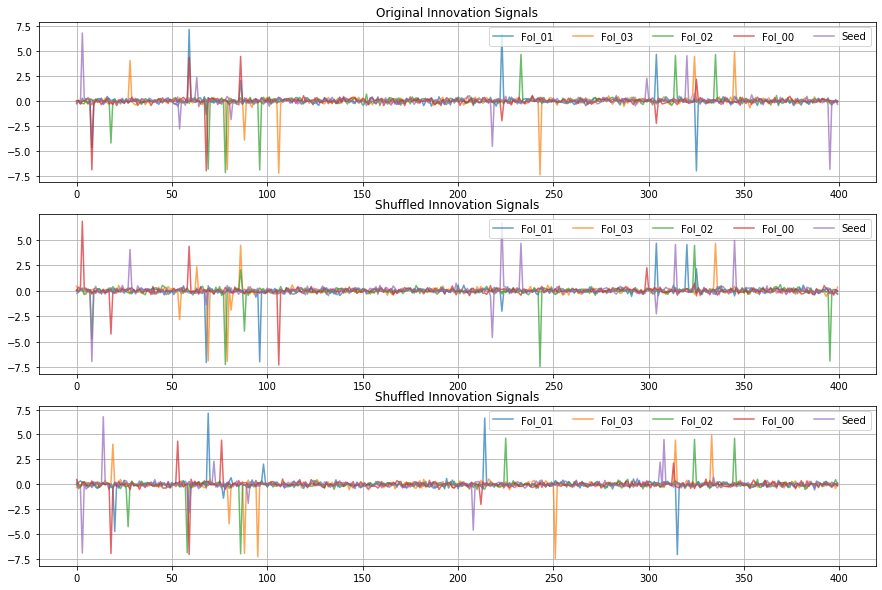

In [106]:
my_inno, s_id, f_id, s_ch = fmri_delay.simulate_activation(n_regions = 5, n_timepoints = 400,
                                                           n_seeds = 1, n_followers = 4,
                                                           fol_levels = [2, 1, 1],
                                                           activ_proba = [2e-2, 100],
                                                           delay = [5, 10, 10],
                                                           noise = 0.2, rand_delay = 0)

permz = fmri_delay.permute_innovations(my_inno, 2)

permz_j = fmri_delay.permute_innovations(my_inno, 2, jitter = 10)

fig, ax = plt.subplots(figsize = (15, 10))

labels = np.full((len(my_inno)), 'Fol_xx')
labels[s_ch] = 'Seed'
labels[f_id] = ['Fol_{:02d}'.format(i) for i, _ in enumerate(f_id)]

plt.subplot(3, 1, 1)
plt.title('Original Innovation Signals')
plt.plot(my_inno.T, alpha = 0.7)
plt.legend(labels, ncol = 5)
plt.grid()

plt.subplot(3, 1, 2)
plt.title('Shuffled Innovation Signals')
plt.plot(permz[0].T, alpha = 0.7)
plt.legend(labels, ncol = 5)
plt.grid()

plt.subplot(3, 1, 3)
plt.title('Shuffled Innovation Signals')
plt.plot(permz_j[0].T, alpha = 0.7)
plt.legend(labels, ncol = 5)
plt.grid()

The above example shows how innovation are re-allocated to new voxels after shuffling.

## Comparison of patterned measurements with and without shuffling


In [54]:
# Simulation Parameters
n_reg, n_timep, n_perm = 100, 800, 1

folevels = [10, 10, 10, 10]

delays = [5, 8, 8, 10]

reprob = 90

simulation, seed_id, fol_id, seed_choice = fmri_delay.simulate_activation(
    n_regions = n_reg, n_timepoints = n_timep,
    n_seeds = 1, n_followers = 40, fol_levels = folevels,
    activ_proba = [5e-2, reprob], delay = delays,
    noise = 0.1, rand_delay = 3)

sim_tresh = fmri_delay.isig_threshold(simulation, z_thresh = 0.5)

# Delay consistency measurement on "patterned" data
del_std_pattern = fmri_delay.delay_measure(sim_tresh, parallel = True, chunksize = 80)

sim_perm = fmri_delay.permute_innovations(sim_tresh, n_perm, jitter = 0, noise = False)

del_std_perm = np.empty((n_perm, n_reg, n_reg))

# Delay consistency measurement on "shuffled" data
for permut_id, permut in enumerate(sim_perm):
    del_std_perm[permut_id] = fmri_delay.delay_measure(permut, parallel = True, chunksize = 80)

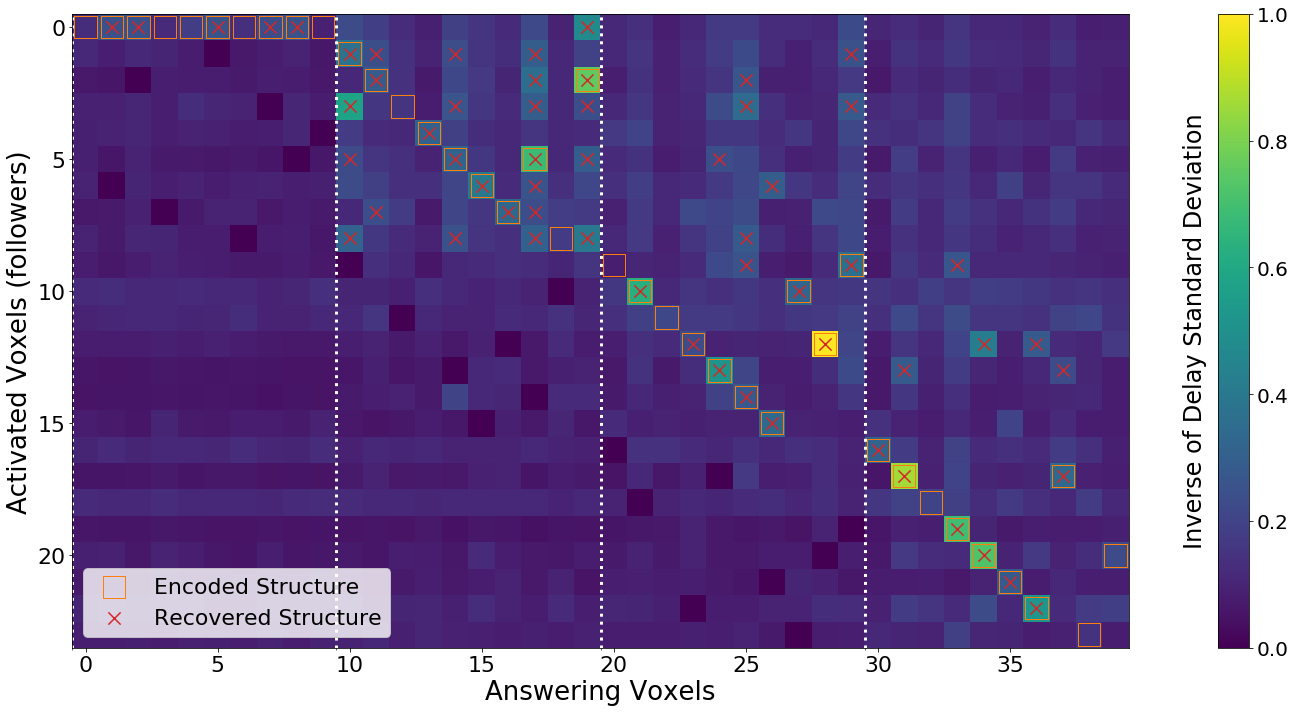

In [112]:
unq = []

for val in seed_choice:
    if val not in unq:
        unq.append(val)

fig, ax = plt.subplots(figsize = (25, 10))

highlight = ([i for i in unq for j in fol_id],
             [j for i in unq for j in fol_id])

expected = fmri_delay.get_encoded_structure(seed_choice, fol_id, n_reg, fol_inter = True)

encoded = np.where(expected[highlight].reshape((len(unq), -1)) == 1)

#plt.title('Without Innovation Shuffling\nZoom on encoded structure', fontsize = 18)

nonan = del_std_pattern.copy()

nonan[np.arange(n_reg), np.arange(n_reg)] = 100
#nonan[np.isnan(nonan)] = 100

plt.imshow(1/nonan[highlight].reshape((len(unq), -1)))
plt.scatter(encoded[1], encoded[0], marker = 's', color="none",
            edgecolor="tab:orange", s = 500, label = 'Encoded Structure')
#730

alevel = 1

bin_res = fmri_delay.empirical_null_dist(del_std_pattern, del_std_perm, alpha_level = alevel)
bin_loc = np.where(bin_res[highlight].reshape((len(unq), -1)) == 1)

#plt.scatter(bin_loc[1], bin_loc[0], marker = 'o', color="none",
#            edgecolor="red", s = 340)

plt.scatter(bin_loc[1], bin_loc[0], marker = 'x', color="tab:red", s = 150,
            label = 'Recovered Structure')

ax.set_xticks([-0.5]*len(folevels) + np.arange(len(folevels)) * folevels, minor = True);
#ax1.set_yticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=3)

plt.tick_params(labelsize = 22)

plt.xlabel('Answering Voxels', fontsize = 26)
plt.ylabel('Activated Voxels (followers)', fontsize = 26)
plt.legend(fontsize = 22)

cbar = plt.colorbar()

cbar.ax.set_ylabel('Inverse of Delay Standard Deviation', fontsize = 24, labelpad = -105)
cbar.ax.tick_params(labelsize = 20)

plt.tight_layout()
plt.savefig('The_Draft/Encode_Binary_NEWCOL')

## Evaluation of measurement on with other voxels (Ranking)

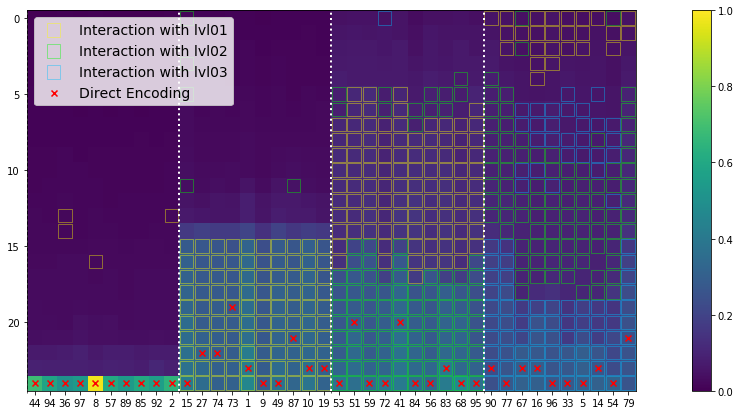

In [132]:
fig, ax = plt.subplots(figsize = (20, 7))

nonan = del_std_pattern.copy()
nonan[np.arange(n_reg), np.arange(n_reg)] = 100

fol_res = 1/nonan[:, fol_id]

srtd = np.sort(fol_res, axis = 0)[-25:]
asrtd = np.argsort(fol_res, axis = 0)[-25:]

plt.imshow(srtd, vmax = 1)

lvlencode = np.zeros_like(asrtd)
lvl_indicator = fol_id.reshape((-1, 10))

for lvl in np.arange(len(folevels) - 1):
    isitin = np.array([valsrtd in lvl_indicator[lvl]
                         for rowsrtd in asrtd for valsrtd in rowsrtd])
    
    lvlencode += isitin.reshape((25, -1))*(1+lvl)

direct_enc = np.where(expected[asrtd, fol_id] == 1)

marksize = 180

for lvl, col in zip(np.arange(len(folevels) - 1),
                    ['yellow','lime', 'deepskyblue', 'grey', 'grey']):
    lvl_enc = np.where(lvlencode == lvl+1)
    plt.scatter(lvl_enc[1], lvl_enc[0], marker = 's', color="none", alpha = 0.4,#-lvl*0.1,
                edgecolor=col, s = marksize,
                label = 'Interaction with lvl{:02d}'.format(lvl+1))


#plt.scatter(direct_enc[1], direct_enc[0], marker = 's', color="none",
#            edgecolor="red", s = marksize, label = 'Direct Encoding')

plt.scatter(direct_enc[1], direct_enc[0], marker = 'x', color="red",
            s = marksize*0.2, label = 'Direct Encoding')



ax.set_xticks([-0.5]*len(folevels) + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

plt.xticks(np.arange(40), fol_id)

plt.legend(loc = 'upper left', fontsize = 14)

plt.colorbar()

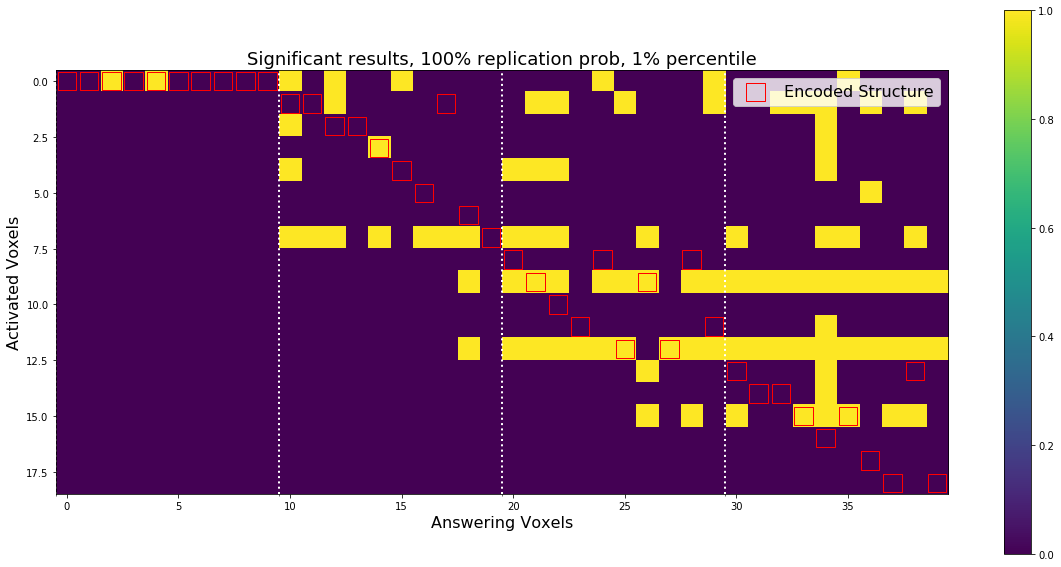

In [121]:
fig, ax = plt.subplots(figsize = (20, 10))

alevel = 1

bin_res = fmri_delay.empirical_null_dist(del_std_pattern, del_std_perm, alpha_level = alevel)

plt.title('Significant results, {}% replication prob, {}% percentile'.format(reprob, alevel), fontsize = 18)

to_show = bin_res[highlight].reshape((len(unq), -1))

plt.imshow(to_show)
plt.scatter(encoded[1], encoded[0], marker = 's', color="none",
            edgecolor="red", s = 340)

ax.set_xticks([-0.5]*len(folevels) + np.arange(len(folevels)) * folevels, minor = True);
#ax1.set_yticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

plt.xlabel('Answering Voxels', fontsize = 16)
plt.ylabel('Activated Voxels', fontsize = 16)
plt.legend(['Encoded Structure'], fontsize = 16)

plt.colorbar()

## Evaluation of FP and FN rates as fct of replication probability
### Re-assignment of innovation to new voxels

In [2]:
## Creating storage object
#esfmri_nojit = {'n_exp':n_exp, 'n_reg':n_reg, 'n_perm':n_perm, 'n_timep':n_timep,
#                'fol_levels':fol_levels, 'delay':delays, 'alevel':alevel, 'jitter':jitter,
#                'replic_prob':replic_prob, 'dc_patt':dc_patt, 'dc_perm':dc_perm,
#                'expected':expected, 'bin_res':bin_res}

# Saving experiments results in a pickle file
with open('../pickle_data/CH_esfmri_toscore.pickle', 'rb') as f:
    esfmri_toscore = pickle.load(f)
    
n_exp = esfmri_toscore['n_exp']
n_reg = esfmri_toscore['n_reg']
n_perm = esfmri_toscore['n_perm']
n_timep = esfmri_toscore['n_timep']
fol_levels = esfmri_toscore['fol_levels']
delay = esfmri_toscore['delay']
jitter = esfmri_toscore['jitter']
replic_prob = esfmri_toscore['replic_prob']
dc_patt = esfmri_toscore['dc_patt']
dc_perm_nojit = esfmri_toscore['dc_perm_nojit']
dc_perm_jit = esfmri_toscore['dc_perm_jit']
expected = esfmri_toscore['expected']
seed_choice = esfmri_toscore['seed_choice']

In [51]:
def plot_hist_2dist(perm_data, patt_data, n_bins = 50, maxrange = 50, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize = (20, 6))

    col = 'tab:red'
    
    for pdat, col in zip(perm_data, ['tab:red', 'tab:orange']):
        ax.hist(pdat.flatten(), n_bins, (0, maxrange), color = col, **kwargs)
        
    ax.legend(['Voxel Reassignment', 'Innovation Jittering'], fontsize = 20, loc = 'upper left')
        
    ax.set_ylabel('Random Distribution', color = col, fontsize = 26)
    ax.tick_params(axis = 'y', labelcolor = col)#, labelsize = 18)
    ax.tick_params(labelsize = 18)

    ax2 = ax.twinx()
    col = 'tab:blue'

    ax2.hist(patt_data.flatten(), n_bins, (0, maxrange), color = col, **kwargs)
    ax2.set_ylabel('Patterned Distribution', color = col, fontsize = 26)
    ax2.tick_params(axis = 'y', labelcolor = col, labelsize = 18)
    
    ax2.legend(['Real Measurement'], fontsize = 20, loc = 'upper right')
    
    ax.set_xlabel('Delay Standard Deviation', fontsize = 26)

    plt.grid()
    
    return ax, ax2

In [33]:
def interactive_hist(subj, reprob, nojit_data, jit_data, patt_data):
    ax1, ax2 = plot_hist_2dist([nojit_data[subj, reprob], jit_data[subj, reprob]],
                               patt_data[subj, reprob],
                               n_bins = 100, maxrange = 40, alpha = 0.7)
    
interact(interactive_hist,
         subj = widgets.IntSlider(min = 0, max = n_exp-1, step = 1, value = 0),
         reprob = widgets.IntSlider(min = 0, max = len(replic_prob)-1, step = 1, value = 0),
         nojit_data = fixed(dc_perm_nojit), jit_data = fixed(dc_perm_jit), patt_data = fixed(dc_patt))

interactive(children=(IntSlider(value=0, description='subj', max=9), IntSlider(value=0, description='reprob', …

<function __main__.interactive_hist(subj, reprob, nojit_data, jit_data, patt_data)>

In [3]:
# Make potential interaction as 0.5
def fix_expected_struct(expect, seed_ch, fol_lvl_size = 10, inter_val = 0.5):
    direct_int = np.where(expect == 1)
    reshaped_sc = seed_ch.reshape((-1, fol_lvl_size))

    lvl_assign =  [[], [], []]

    for aseed, afol in zip(*direct_int):

        lvl = np.where(reshaped_sc == aseed)[0][0]

        if lvl != 0:
            for to_put in range(lvl, 4, 1):
                lvl_assign[to_put - 1].append(afol)
                
    interlvl = np.zeros_like(expected[0, 0])

    for lvl_id, lvls in enumerate(lvl_assign):
        u_seeds = np.unique(reshaped_sc[lvl_id + 1])

        interlvl[[fol_x for fol_x in lvls for _ in u_seeds],
                 [int(seed_y) for _ in lvls for seed_y in u_seeds]] = inter_val
        
    return np.clip(expect + interlvl, 0, 1)

In [56]:
emp_perc = 1

fal_neg_reassign = np.empty((n_exp, len(replic_prob), 2))
fal_pos_reassign = np.empty_like(fal_neg_reassign)

bin_res_nojit = np.empty((n_exp, len(replic_prob), n_reg, n_reg))
expectations = np.empty_like(bin_res_nojit)

for exp in range(n_exp):
    for rp_id, rp in enumerate(replic_prob):
        bin_res_nojit[exp, rp_id] = fmri_delay.empirical_null_dist(real_meas = dc_patt[exp, rp_id],
                                                 rand_meas = dc_perm_nojit[exp, rp_id],
                                                 alpha_level = emp_perc)
        
        expectations[exp, rp_id] = fix_expected_struct(expected[exp, rp_id], seed_choice[exp, rp_id])
        
    
        
        fal_neg_reassign[exp, rp_id], fal_pos_reassign[exp, rp_id] = fmri_delay.recovery_score(bin_res_nojit[exp,
                                                                                                             rp_id],
                                                                                               expectations[exp,
                                                                                                            rp_id],
                                                                                               fol_inter = True)

/Users/AlexCionca/miniconda3/PROJ/_PDM/fmri_delay/fmri_delay/validation.py:123: RuntimeWarning: invalid value encountered in less
  bin_results = (real_meas < empirical_bound).astype(int)


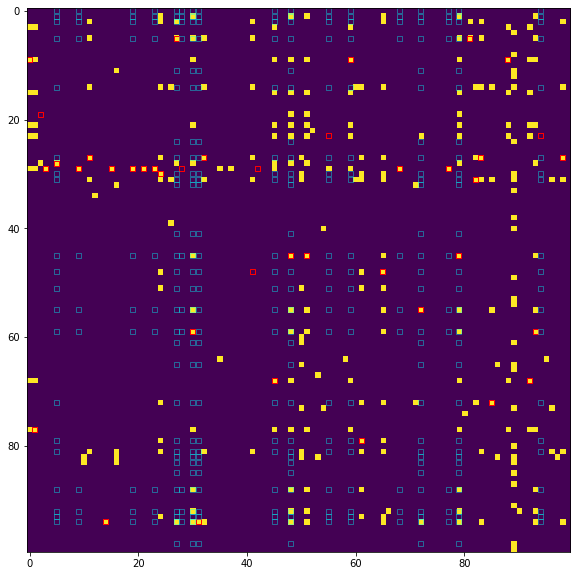

In [5]:
fig, ax = plt.subplots(figsize = (10, 10))

whichexp = 0
whichprob = -2

plt.imshow(bin_res_nojit[whichexp, whichprob])

enc = np.where(expected[whichexp, whichprob] == 1)
plt.scatter(enc[1], enc[0], marker = 's', color="none", edgecolor="red", s = 25)

enc = np.where(expectations[whichexp, whichprob] == 0.5)
plt.scatter(enc[1], enc[0], marker = 's', color="none", edgecolor="cyan", s = 25, alpha = 0.4)

In [6]:
def inter_highight_res(experiment, reprob_id, meas, bin_res, expec):
    fig, ax = plt.subplots(figsize = (20, 10))
    plt.title('Significant results, {}% replication prob, {}% percentile'
              .format(replic_prob[reprob_id], emp_perc), fontsize = 18)
    
    exp_ones = np.where(expec[experiment, reprob_id] == 1)
    
    highlight = ([i for i in np.unique(exp_ones[0]) for j in exp_ones[1]],
                 [j for i in np.unique(exp_ones[0]) for j in exp_ones[1]])
    
    to_show = meas[experiment, reprob_id][highlight].reshape((len(np.unique(exp_ones[0])), -1))
    
    plt.imshow(to_show)
    
    encoded = np.where(expec[experiment, reprob_id][highlight].reshape((len(np.unique(exp_ones[0])), -1)) == 1)
    
    plt.scatter(encoded[1], encoded[0], marker = 's', color="none",
                edgecolor="red", s = 420)
    
    recovered = np.where(bin_res[experiment, reprob_id][highlight].reshape((len(np.unique(exp_ones[0])), -1)) == 1)
    
    plt.scatter(recovered[1], recovered[0], marker = 'x', color="red", s = 420)

    ax.set_xticks([-0.5]*len(fol_levels) + np.arange(len(fol_levels)) * fol_levels, minor = True);
    ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

    plt.xlabel('Answering Voxels', fontsize = 16)
    plt.ylabel('Activated Voxels', fontsize = 16)
    plt.legend(['Encoded Structure'], fontsize = 16)

    plt.colorbar()
    
    return

interact(inter_highight_res,
         experiment = widgets.IntSlider(min = 0, max = n_exp-1, step = 1, value = 0),
         reprob_id = widgets.IntSlider(min = 0, max = len(replic_prob)-1, step = 1, value = 0),
         meas = fixed(1/dc_patt), bin_res = fixed(bin_res_nojit), expec = fixed(expected))

interactive(children=(IntSlider(value=0, description='experiment', max=9), IntSlider(value=0, description='rep…

<function __main__.inter_highight_res(experiment, reprob_id, meas, bin_res, expec)>

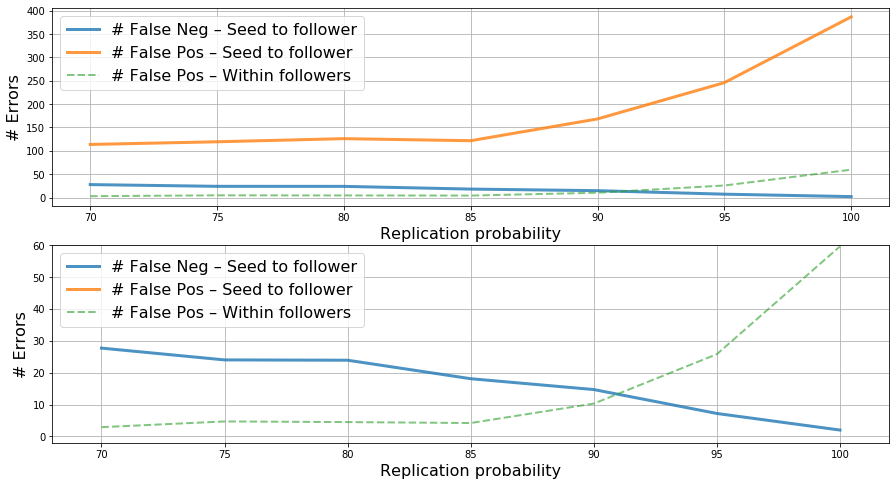

In [7]:
fig, ax = plt.subplots(figsize = (15, 8))

for i in range(2):
    plt.subplot(2, 1, 1 + i)

    plt.plot(replic_prob, fal_neg_reassign[:, :, 0].mean(axis = 0), alpha = 0.8,
             label = '# False Neg – Seed to follower', linewidth = 3)
    plt.plot(replic_prob, fal_pos_reassign[:, :, 0].mean(axis = 0), alpha = 0.8,
             label = '# False Pos – Seed to follower', linewidth = 3)

    #plt.plot(replic_prob, fal_neg_reassign[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
    #         label = '# False Neg – Within followers', linewidth = 2)
    plt.plot(replic_prob, fal_pos_reassign[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
             label = '# False Pos – Within followers', linewidth = 2)

    plt.xlabel('Replication probability', fontsize = 16)
    plt.ylabel('# Errors', fontsize = 16)
    
    if i == 1:
        plt.axis([68, 102, -2, 60])

    plt.grid()
    plt.legend(fontsize = 16)

### Jittering

In [57]:
fal_neg_jit = np.empty((n_exp, len(replic_prob), 2))
fal_pos_jit = np.empty_like(fal_neg_jit)

bin_res_jit = np.empty((n_exp, len(replic_prob), n_reg, n_reg))

for exp in range(n_exp):
    for rp_id, rp in enumerate(replic_prob):
        bin_res_jit[exp, rp_id] = fmri_delay.empirical_null_dist(real_meas = dc_patt[exp, rp_id],
                                                 rand_meas = dc_perm_jit[exp, rp_id],
                                                 alpha_level = emp_perc)
        
        expectations = fix_expected_struct(expected[exp, rp_id], seed_choice[exp, rp_id])
        
        fal_neg_jit[exp, rp_id], fal_pos_jit[exp, rp_id] = fmri_delay.recovery_score(bin_res_jit[exp, rp_id],
                                                                                     expectations,
                                                                                     fol_inter = True)

In [9]:
interact(inter_highight_res,
         experiment = widgets.IntSlider(min = 0, max = n_exp-1, step = 1, value = 0),
         reprob_id = widgets.IntSlider(min = 0, max = len(replic_prob)-1, step = 1, value = 0),
         meas = fixed(1/dc_patt), bin_res = fixed(bin_res_jit), expec = fixed(expected))

interactive(children=(IntSlider(value=0, description='experiment', max=9), IntSlider(value=0, description='rep…

<function __main__.inter_highight_res(experiment, reprob_id, meas, bin_res, expec)>

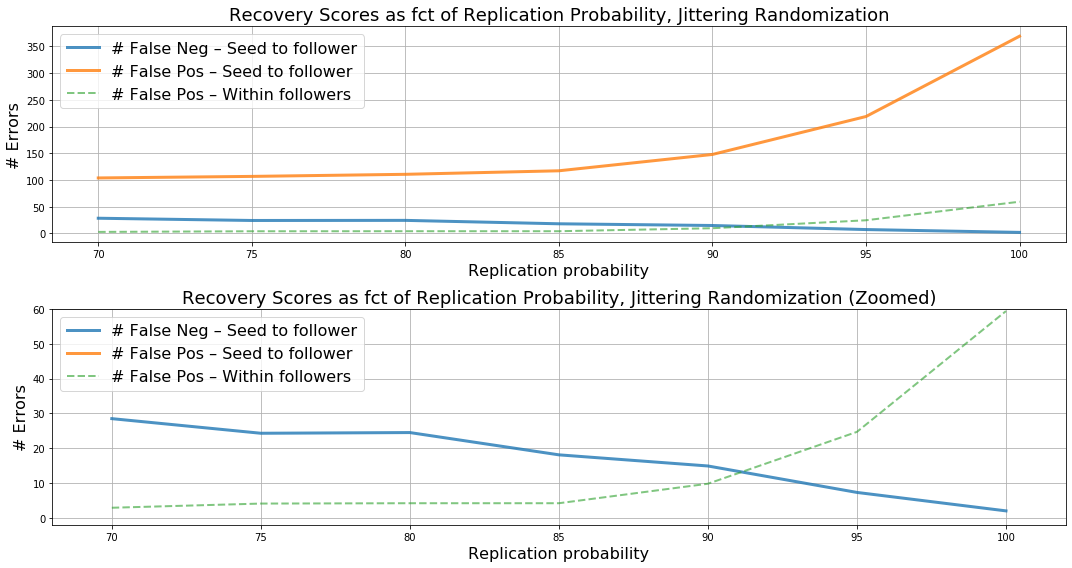

In [10]:
fig, ax = plt.subplots(figsize = (15, 8))

title = 'Recovery Scores as fct of Replication Probability, Jittering Randomization'

for i in range(2):
    plt.subplot(2, 1, 1 + i)
    
    plt.title(title + i*' (Zoomed)', fontsize = 18)

    plt.plot(replic_prob, fal_neg_jit[:, :, 0].mean(axis = 0), alpha = 0.8,
             label = '# False Neg – Seed to follower', linewidth = 3)
    plt.plot(replic_prob, fal_pos_jit[:, :, 0].mean(axis = 0), alpha = 0.8,
             label = '# False Pos – Seed to follower', linewidth = 3)

    #plt.plot(replic_prob, fal_neg_jit[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
    #         label = '# False Neg – Within followers', linewidth = 2)
    plt.plot(replic_prob, fal_pos_jit[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
             label = '# False Pos – Within followers', linewidth = 2)

    plt.xlabel('Replication probability', fontsize = 16)
    plt.ylabel('# Errors', fontsize = 16)
    
    if i == 1:
        plt.axis([68, 102, -2, 60])

    plt.grid()
    plt.legend(fontsize = 16)
    
plt.tight_layout()

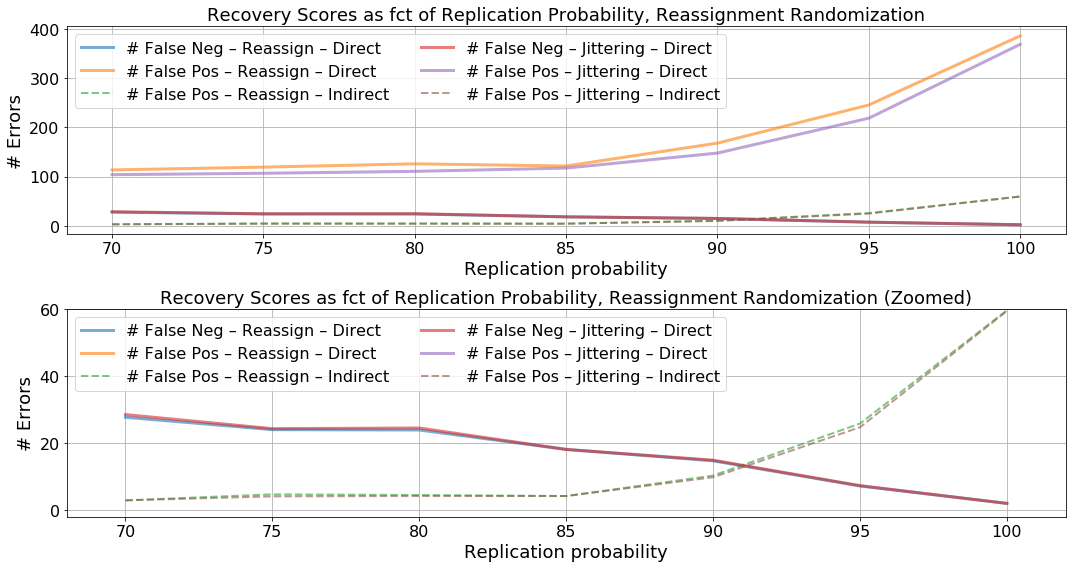

In [60]:
fig, ax = plt.subplots(figsize = (15, 8))

title = 'Recovery Scores as fct of Replication Probability, Reassignment Randomization'

for i in range(2):
    plt.subplot(2, 1, 1 + i)
    
    plt.title(title + i*' (Zoomed)', fontsize = 18)

    plt.plot(replic_prob, fal_neg_reassign[:, :, 0].mean(axis = 0), alpha = 0.6,
             label = '# False Neg – Reassign – Direct', linewidth = 3)
    plt.plot(replic_prob, fal_pos_reassign[:, :, 0].mean(axis = 0), alpha = 0.6,
             label = '# False Pos – Reassign – Direct', linewidth = 3)

    #plt.plot(replic_prob, fal_neg_reassign[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
    #         label = '# False Neg – Within followers', linewidth = 2)
    plt.plot(replic_prob, fal_pos_reassign[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
             label = '# False Pos – Reassign – Indirect', linewidth = 2)
    
    plt.plot(replic_prob, fal_neg_jit[:, :, 0].mean(axis = 0), alpha = 0.6,
             label = '# False Neg – Jittering – Direct', linewidth = 3)
    plt.plot(replic_prob, fal_pos_jit[:, :, 0].mean(axis = 0), alpha = 0.6,
             label = '# False Pos – Jittering – Direct', linewidth = 3)
    
    plt.plot(replic_prob, fal_pos_jit[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
             label = '# False Pos – Jittering – Indirect', linewidth = 2)

    plt.xlabel('Replication probability', fontsize = 18)
    plt.ylabel('# Errors', fontsize = 18)
    
    if i == 1:
        plt.axis([68, 102, -2, 60])
        
    plt.tick_params(labelsize = 16)

    plt.grid()
    plt.legend(fontsize = 16, ncol = 2)
    
plt.tight_layout()

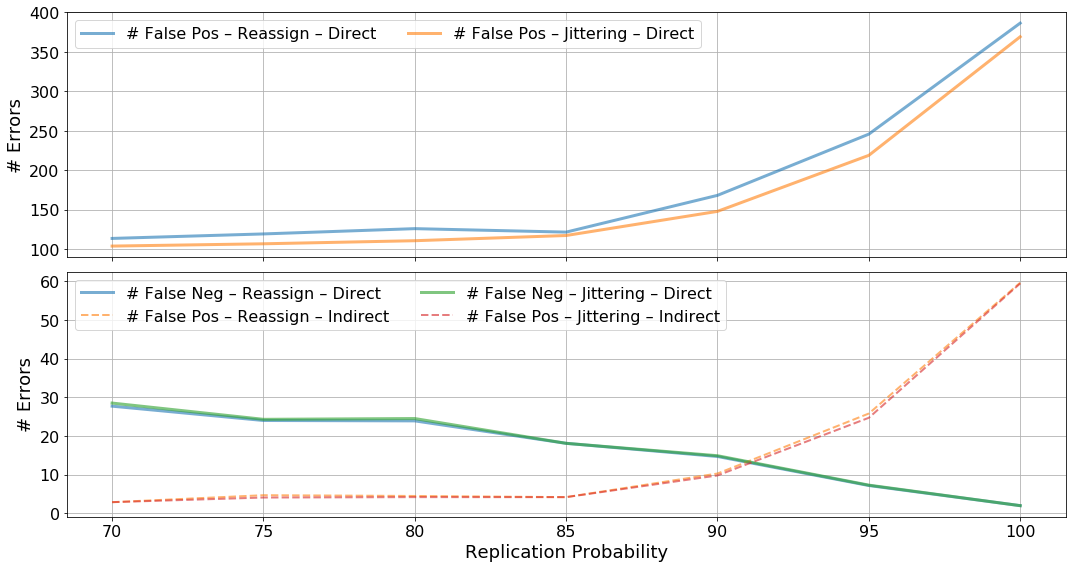

In [72]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 8), nrows=2, sharex=True)

fig.subplots_adjust(hspace = 0)

#title = 'Recovery Scores as fct of Replication Probability, Reassignment Randomization'


#ax1.set_title(title, fontsize = 18)


ax1.plot(replic_prob, fal_pos_reassign[:, :, 0].mean(axis = 0), alpha = 0.6,
         label = '# False Pos – Reassign – Direct', linewidth = 3)

ax1.plot(replic_prob, fal_pos_jit[:, :, 0].mean(axis = 0), alpha = 0.6,
         label = '# False Pos – Jittering – Direct', linewidth = 3)

ax1.set_ylabel('# Errors', fontsize = 18)
ax1.tick_params(labelsize = 16)

ax1.grid()
ax1.legend(fontsize = 16, ncol = 2)

ax2.plot(replic_prob, fal_neg_reassign[:, :, 0].mean(axis = 0), alpha = 0.6,
         label = '# False Neg – Reassign – Direct', linewidth = 3)

ax2.plot(replic_prob, fal_pos_reassign[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
         label = '# False Pos – Reassign – Indirect', linewidth = 2)

ax2.plot(replic_prob, fal_neg_jit[:, :, 0].mean(axis = 0), alpha = 0.6,
         label = '# False Neg – Jittering – Direct', linewidth = 3)

ax2.plot(replic_prob, fal_pos_jit[:, :, 1].mean(axis = 0), '--', alpha = 0.6,
         label = '# False Pos – Jittering – Indirect', linewidth = 2)


ax2.set_ylabel('# Errors', fontsize = 18)
ax2.set_xlabel('Replication Probability', fontsize = 18)
ax2.tick_params(labelsize = 16)

ax2.grid()
ax2.legend(fontsize = 16, ncol = 2)

plt.tight_layout()

plt.savefig('The_Draft/Recovery_scores')

## Measured consistency on encoded and overall structure as FCT of reprob

In [4]:
encoded_meas = np.empty((len(replic_prob), n_exp, len(seed_choice[0, 0])))
overall_meas = [0]*len(replic_prob)

n_rand_val = 10

encoded_nojit = [[]*n_exp]*len(replic_prob)
encoded_jit = [[]]*len(replic_prob)

overall_nojit = [[]]*len(replic_prob)
overall_jit = [[]]*len(replic_prob)

for rp_id, _ in enumerate(replic_prob):
    
    encoded_measures = np.array([])
    #overall_measures = np.array([])
    
    overall_measures = []
    
    e_nojit = []
    e_jit = []
    o_nojit = []
    o_jit = []
    
    #e_nojit = np.array([])
    #e_jit = np.array([])
    #
    #o_nojit = np.array([])
    #o_jit = np.array([])
    
    for exp in range(n_exp):
        
        meas = dc_patt[exp, rp_id]
        nojit = dc_perm_nojit[exp, rp_id, :n_rand_val]
        jit = dc_perm_jit[exp, rp_id, :n_rand_val]
        
        #encoded_measures = np.hstack((encoded_measures, meas[expected[exp, rp_id] > 0]))
        #overall_measures = np.hstack((overall_measures, meas[~ np.isnan(meas)]))
        
        encoded_meas[rp_id, exp] = meas[expected[exp, rp_id] > 0]
        
        nonan = meas[expected[exp, rp_id] == 0]
        
        overall_measures.append(nonan[~ np.isnan(nonan)])
        #overall_measures.append(meas[~ np.isnan(meas)])
        
        nonan = nojit[:, expected[exp, rp_id] > 0].flatten()
        
        e_nojit.append(nonan[~ np.isnan(nonan)])
        o_nojit.append(nojit[~ np.isnan(nojit)])
        
        nonan = jit[:, expected[exp, rp_id] > 0].flatten()
        
        e_jit.append(nonan[~ np.isnan(nonan)])
        o_jit.append(jit[~ np.isnan(jit)])
        
        #e_nojit = np.hstack((e_nojit, nojit[:, expected[exp, rp_id] > 0].flatten()))
        #e_jit = np.hstack((e_jit, jit[:, expected[exp, rp_id] > 0].flatten()))
        #
        #o_nojit = np.hstack((o_nojit, nojit[~ np.isnan(nojit)]))
        #o_jit = np.hstack((o_jit, jit[~ np.isnan(jit)]))
    
    #encoded_meas[rp_id] = encoded_measures
    overall_meas[rp_id] = overall_measures
    
    overall_nojit[rp_id] = o_nojit
    overall_jit[rp_id] = o_jit
    
    encoded_nojit[rp_id] = e_nojit
    encoded_jit[rp_id] = e_jit

In [5]:
def conf_int(sd, n_obs=20, tstat = 2.756):
    # Two sided 95%: tstat = 1.96, 99%: tstat = 2.756
    return tstat*sd/np.sqrt(n_obs)

def bootstrap_ci(data, perc = 5, n_trials = 100):
    
    bootstraped = np.empty((len(data), n_trials))
    
    for row_id, row in enumerate(data):
        bootstraped[row_id] = np.mean(np.random.choice(row, (len(row), n_trials), replace = True), axis = 0)
            
    lower = np.percentile(bootstraped, perc/2, axis = 1, interpolation = 'nearest')
    upper = np.percentile(bootstraped, 100 - perc/2, axis = 1, interpolation = 'nearest')
    
    return lower, upper

In [55]:
def inter_shit(rep_id, exp):
    fig, ax = plt.subplots(figsize = (20, 10))
    
    for i, to_compare in enumerate([overall_meas, [encoded_nojit, encoded_jit],
                                    [overall_nojit, overall_jit, overall_meas]]):
        
        plt.suptitle('Distribution of Delay Consistency Measurements\n'+
                     '({} Independant Experiments – {}% Replication Probability)'
                     .format(n_exp, replic_prob[rep_id]), fontsize = 22)
        
        if i < 2:
            ax1 = plt.subplot(2, 2, 1 + i)
            label_prefix = 'Encoded '
        else:
            ax1 = plt.subplot(2, 1, 2)
            label_prefix = 'All '
        
        #plt.title('Delay Measurement Results as a Function of Replication Probability\n'+
        #          '(mean and CI over {} Experiments – {}% Replication Probability)'
        #          .format(n_exp, replic_prob[rep_id]), fontsize = 22)
        
        label = []

        col = 'green'
        
        if exp is None:
            pass
        else:
            ax1.hist(encoded_meas[rep_id, exp], bins = 50, alpha = 0.6, color = col, range = (0, 40),
                     label = 'Encoded interactions – Structured data')
        
        #if i == 2:
        #    #ax1.plot(np.full(2, np.percentile(encoded_meas[rep_id, exp], 75)), [0, 5], color = col)
        #    ax1.plot(np.full(2, np.mean(encoded_meas[rep_id, exp])), [0, 5], color = col)
        
        ax2 = ax1.twinx()
        
        if i > 0:
            if exp is None:
                ax2.hist(to_compare[0][rep_id][exp], bins = 50, alpha = 0.5, color = 'red', range = (0, 40),
                         label = label_prefix+'interactions – Re-assigned data')

                ax2.hist(to_compare[1][rep_id][exp], bins = 50, alpha = 0.5, color = 'orange', range = (0, 40),
                         label = label_prefix+'interactions – Jittered data')
            else:
                ax2.hist(to_compare[0][rep_id][exp], bins = 50, alpha = 0.5, color = 'red', range = (0, 40),
                         label = label_prefix+'interactions – Re-assigned data')

                ax2.hist(to_compare[1][rep_id][exp], bins = 50, alpha = 0.5, color = 'orange', range = (0, 40),
                         label = label_prefix+'interactions – Jittered data')
            #if i == 2:
            #    ax2.plot(np.full(2, np.percentile(to_compare[0][rep_id][exp], 5)), [0, 10000], color = 'red')
            #    ax2.plot(np.full(2, np.percentile(to_compare[1][rep_id][exp], 5)), [0, 10000], color = 'orange')
        else:
            if exp is None:
                pass
            else:
                ax2.hist(to_compare[rep_id][exp], bins = 50, alpha = 0.6, color = 'lightblue', range = (0, 40),
                         label = 'All interactions – Structured data')

        plt.xlabel('Measured Delay s.d.', fontsize = 18)
        #plt.ylabel('Frequency', fontsize = 18)
        plt.tick_params(labelsize = 16)

        plt.grid()
        
        ax1.legend(loc = 'upper left', bbox_to_anchor=(0.5, 1))
        ax2.legend(loc = 'upper left', bbox_to_anchor=(0.5, 0.92))
    
interact(inter_shit,
         rep_id = widgets.IntSlider(min = 0, max = len(replic_prob) - 1, step = 1, value = 0),
         exp = widgets.IntSlider(min = 0, max = n_exp - 1, step = 1, value = 0))

#interact(inter_shit,
#         rep_id = widgets.IntSlider(min = 0, max = len(replic_prob) - 1, step = 1, value = 0),
#         exp = fixed(None))

interactive(children=(IntSlider(value=0, description='rep_id', max=6), IntSlider(value=0, description='exp', m…

<function __main__.inter_shit(rep_id, exp)>

# EXP 8 IS SHIT

In [20]:
def distriplot(x, y, alpha, ax, use_perc = 0, with_exp = False, excl_exp = [], bootstrap = False, **kwargs):
    exp_filter = [not exper in excl_exp for exper in range(n_exp)]
    
    if type(y) == list:
        if with_exp:
            mean = np.array([])
            std = np.array([])
            
            y_adj = [0]*len(x)
            
            for i, all_exp in enumerate(y):
                one_exp = []
                for exp_i, ind_exp in enumerate(all_exp):
                    if not exp_i in excl_exp:
                        one_exp.extend(ind_exp)
                
                y_adj[i] = one_exp
        else:
            y_adj = y
            
        mean = np.array([np.mean(row) for row in y_adj])
        std = np.array([np.std(row) for row in y_adj])
    else:
        if with_exp:
            y_adj = y[:, exp_filter].reshape((len(x), -1))
        else:
            y_adj = y
        
        mean = np.mean(y_adj, axis = 1)
        std = np.std(y_adj, axis = 1)
    
    ax.plot(x, mean, linewidth = 2, **kwargs)
    
    if bootstrap:
        lower, upper = bootstrap_ci(y_adj, perc = 1, n_trials = 1000)
        
        #upper = [np.percentile(row, 100 - use_perc) for row in y]
        #lower = [np.percentile(row, use_perc) for row in y]
        
        ax.fill_between(x, lower, upper, alpha = alpha)
    else:
        #ci = std
        #ci = conf_int(std, len(y_adj[0]), 2.576)
        ci = conf_int(std, n_exp - len(excl_exp), 1.96)
        
        ax.fill_between(x, mean - ci, mean + ci, alpha = alpha)

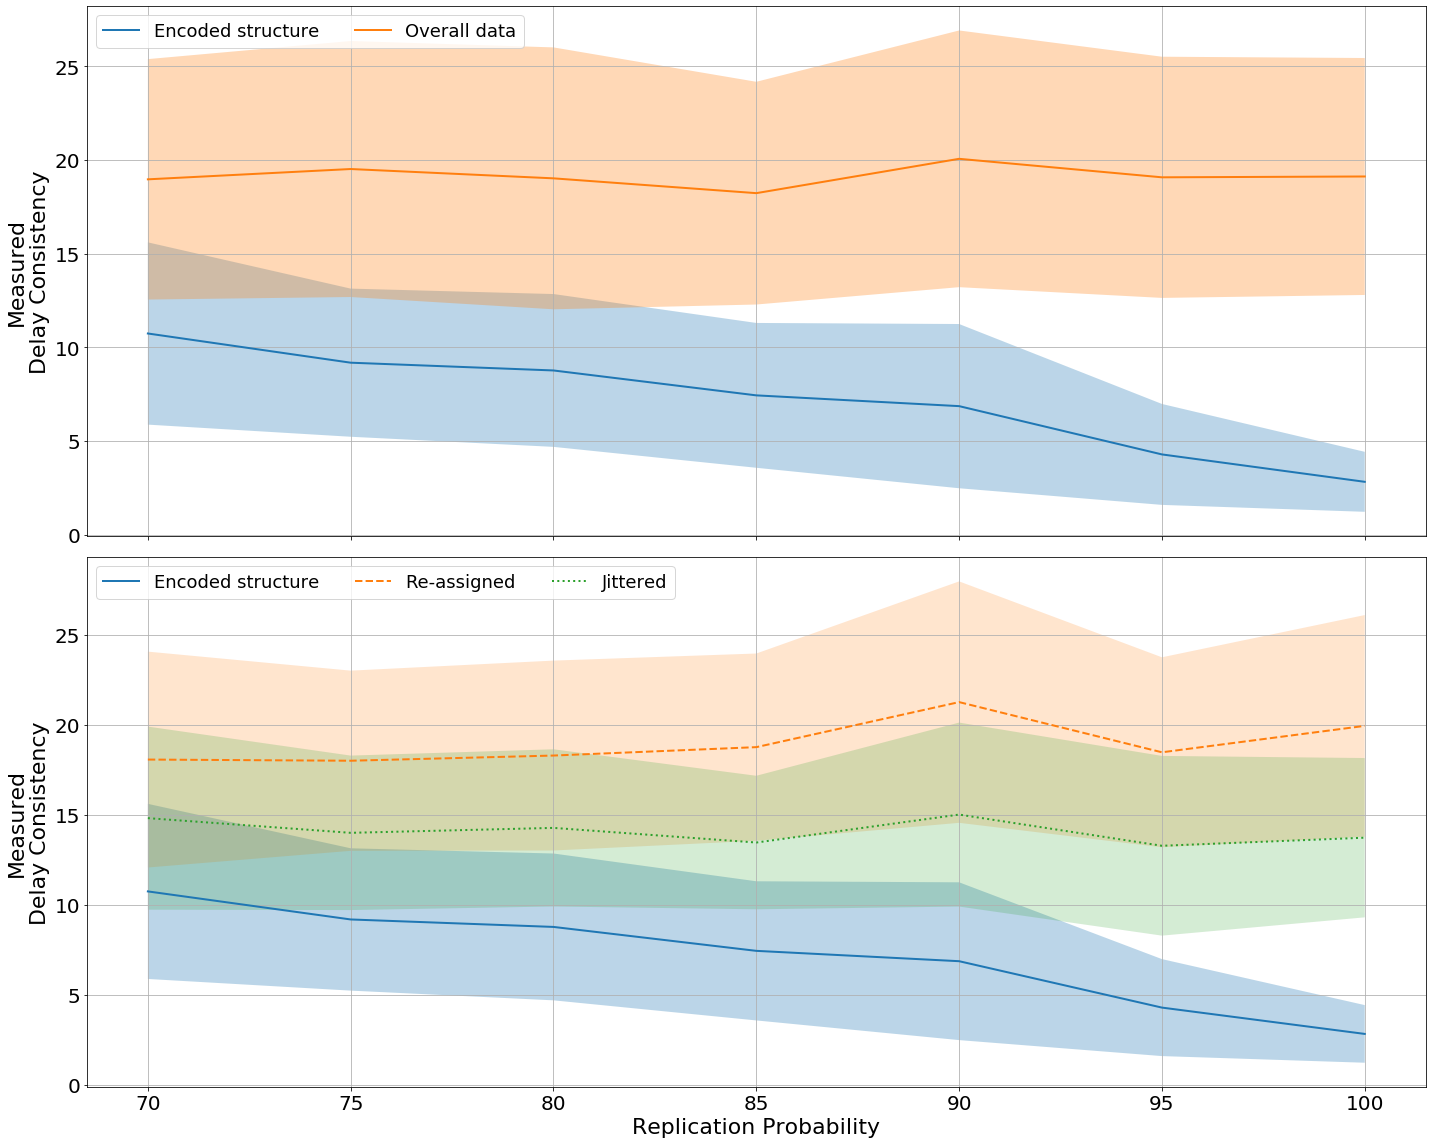

In [21]:
fig, ax = plt.subplots(figsize = (20, 16))

exclude = [8]

use_encode_rand = True

for i, randata in enumerate([False, True]):
    ax1 = plt.subplot(2, 1, 1 + i)

    distriplot(replic_prob, encoded_meas, alpha = 0.3, ax = ax1, with_exp = True, excl_exp = exclude,
               label = 'Encoded structure')

    if randata:
        if use_encode_rand:
            distriplot(replic_prob, encoded_nojit, alpha = 0.2, ax = ax1, with_exp = True, excl_exp = exclude,
                       linestyle = '--', label = 'Re-assigned')
            distriplot(replic_prob, encoded_jit, alpha = 0.2, ax = ax1, with_exp = True, excl_exp = exclude,
                       linestyle = ':', label = 'Jittered')
        else:
            distriplot(replic_prob, overall_nojit, alpha = 0.2, ax = ax1, with_exp = True, excl_exp = exclude,
                   linestyle = '--', label = 'Re-assigned')
            distriplot(replic_prob, overall_jit, alpha = 0.2, ax = ax1, with_exp = True, excl_exp = exclude,
                   linestyle = ':', label = 'Jittered')
    else:
        distriplot(replic_prob, overall_meas, alpha = 0.3, ax = ax1, with_exp = True, excl_exp = exclude,
                   label = 'Overall data')
    
    if i > 0:
        plt.xlabel('Replication Probability', fontsize = 22)
        
    plt.tick_params(labelsize = 20, labelbottom = i)
        
    plt.ylabel('Measured\nDelay Consistency', fontsize = 22)

    plt.legend(loc = 'upper left', fontsize = 18, ncol = 2 + i)
    
    plt.grid()
    
plt.tight_layout()

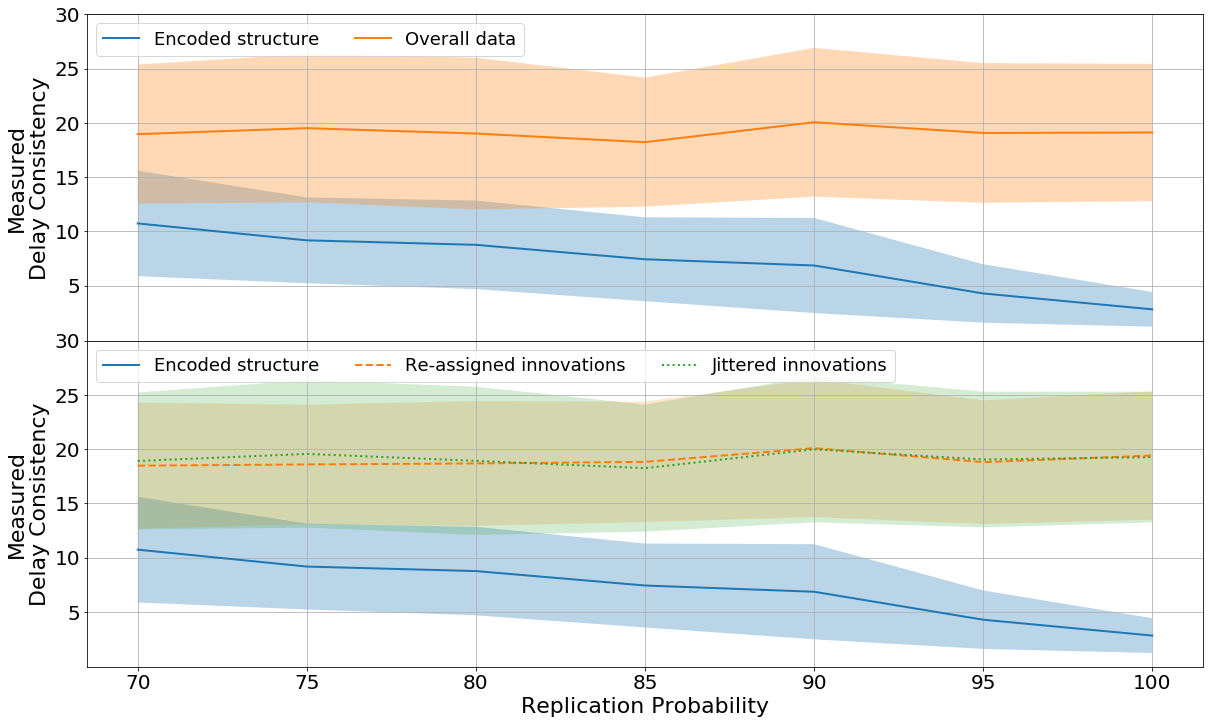

In [46]:
fig, axs = plt.subplots(figsize = (20, 12), nrows = 2, ncols = 1, sharex = True)

fig.subplots_adjust(hspace = 0)

for i, randata in enumerate([False, True]):

    distriplot(replic_prob, encoded_meas, alpha = 0.3, ax = axs[i], with_exp = True, excl_exp = exclude, 
               label = 'Encoded structure')

    if randata:
        distriplot(replic_prob, overall_nojit, alpha = 0.2, ax = axs[i], with_exp = True, excl_exp = exclude,  
                   linestyle = '--',
                   label = 'Re-assigned innovations')
        distriplot(replic_prob, overall_jit, alpha = 0.2, ax = axs[i], with_exp = True, excl_exp = exclude, 
                   linestyle = ':',
                   label = 'Jittered innovations')
    else:
        distriplot(replic_prob, overall_meas, alpha = 0.3, ax = axs[i], with_exp = True, excl_exp = exclude, 
                   label = 'Overall data')
    
    if i > 0:
        plt.xlabel('Replication Probability', fontsize = 22)
        
    
    axs[i].tick_params(labelsize = 20, labelbottom = i)
        
    axs[i].set_ylabel('Measured\nDelay Consistency', fontsize = 22)
    
    #axs[i].axis([60, 100, 0, 35])
    axs[i].set_yticks(np.arange(5, 35, 5))

    axs[i].legend(loc = 'upper left', fontsize = 18, ncol = 2 + i)

    axs[i].grid()
    
plt.savefig('The_Draft/Reproba_FillBetween')

In [32]:
encoded_meas.shape

(7, 10, 40)

In [30]:
len(overall_meas)

7

In [43]:
for rpid in range(7):
    print('## Rep Prob {:02d} ##'.format(rpid + 1))
    for exp in range(10):
        mean1 = np.nanmean(encoded_meas[rpid, exp])
        std1 = np.nanstd(encoded_meas[rpid, exp])
        n_obs1 = len(encoded_meas[rpid, exp])
        
        mean2 = np.nanmean(overall_meas[rpid][exp])
        std2 = np.nanstd(overall_meas[rpid][exp])
        n_obs2 = len(overall_meas[rpid][exp])
        
        tval, pval = stats.ttest_ind_from_stats(mean1, std1, n_obs1, mean2, std2, n_obs2)
        
        print(tval, pval*70/2)

## Rep Prob 01 ##
-5.978052458844318 8.176768815835777e-08
-5.821588805977081 2.1036432903203277e-07
-6.81849721572072 3.4079210906838087e-10
-6.34041981252405 8.369885437547999e-09
-4.241870598574647 0.0007828861227260368
-4.065964065112567 0.0016871638618961235
-5.852349877349733 1.750243569313327e-07
-7.512351372863407 2.2084321253459955e-12
-5.415711907243058 2.186613401862235e-06
-2.9667794351047787 0.10557962196412919
## Rep Prob 02 ##
-6.390494349275451 6.047865001331773e-09
-5.908565502670223 1.2476879131639572e-07
-7.995687145386765 5.014095856631886e-14
-7.121718897248081 3.99027917527435e-11
-5.32844354081722 3.5432081205017442e-06
-5.140773255659444 9.759290459560666e-06
-6.337843027112706 8.510455676654221e-09
-6.365535597267796 7.113298487619922e-09
-8.841854833405458 3.8569475831677027e-17
-6.232048524988843 1.6769650892852564e-08
## Rep Prob 03 ##
-6.282439948973829 1.2156292196955188e-08
-8.335741277446632 3.0539504241429702e-15
-6.983103867871341 1.0755096844936316e-1

In [ ]:
## Stat test of diff between seed and rest
tval, pval = stats.ttest_1samp(rest_meas, seed_meas, axis = 0, nan_policy = 'omit')

corr_p = 9*len(seed_meas)*pval/2

is_sig_smaller = (corr_p < 0.005) & (tval > 0)
sig_followers += is_sig_smaller

## Variance in binarized results as fct of random sample size

In [9]:
def jaccard_sim(matrix1, matrix2):
    intersect = np.sum(matrix1 + matrix2 == 2)
    union = np.sum(matrix1 + matrix2 > 0)
    
    return intersect/union

In [10]:
dc_patt
dc_perm_nojit
dc_perm_jit

reprob_id = 0

rand_exp = 100
sample_sizes = np.arange(2, 102, 2)

MSE = np.empty((len(replic_prob), len(sample_sizes), rand_exp))

mean_diff = np.empty((len(replic_prob), len(sample_sizes)))
std_diff = np.empty_like(mean_diff)

jaccard = np.empty((len(replic_prob), len(sample_sizes), rand_exp))

rexp = np.random.choice(10)
for rep_id, _ in enumerate(replic_prob):
    for s_id, s_size in enumerate(sample_sizes):
        
        b_res = np.empty((rand_exp, n_reg, n_reg))
        for exp in range(rand_exp):
            rand_choice = np.random.choice(100, s_size)
            b_res[exp] = fmri_delay.empirical_null_dist(dc_patt[rexp, rep_id],
                                                        dc_perm_nojit[rexp, rep_id,
                                                                      rand_choice],
                                                        alpha_level = 5)
        
        
        sigres = b_res.sum(axis = 0).astype(bool)
        
        for exp in range(rand_exp):
            jaccard[rep_id, s_id, exp] = jaccard_sim(sigres, b_res[exp])
            
        
        #MSE[rep_id, s_id] = np.power(sigres - b_res, 2).mean(axis = 1).mean(axis = 1)
        #
        ##MSE = np.power(sigres - b_res, 2)
        #
        #mean_diff[rep_id, s_id] = MSE[rep_id, s_id].mean()
        #std_diff[rep_id, s_id] = MSE[rep_id, s_id].std()

In [74]:
def inter_randsize(rep_id):

    fig, ax = plt.subplots(figsize = (15, 6))

    plt.plot(sample_sizes, mean_diff[rep_id])

    lower, upper = bootstrap_ci(MSE[rep_id], n_trials = 1000)

    plt.fill_between(sample_sizes, lower, upper, alpha = 0.4)

    plt.grid()
    
    return

interact(inter_randsize, rep_id = widgets.IntSlider(min=0, max=len(replic_prob) - 1, step=1, value = 0))

interactive(children=(IntSlider(value=0, description='rep_id', max=6), Output()), _dom_classes=('widget-intera…

<function __main__.inter_randsize(rep_id)>

REPLICATION PROBABILITY = 90


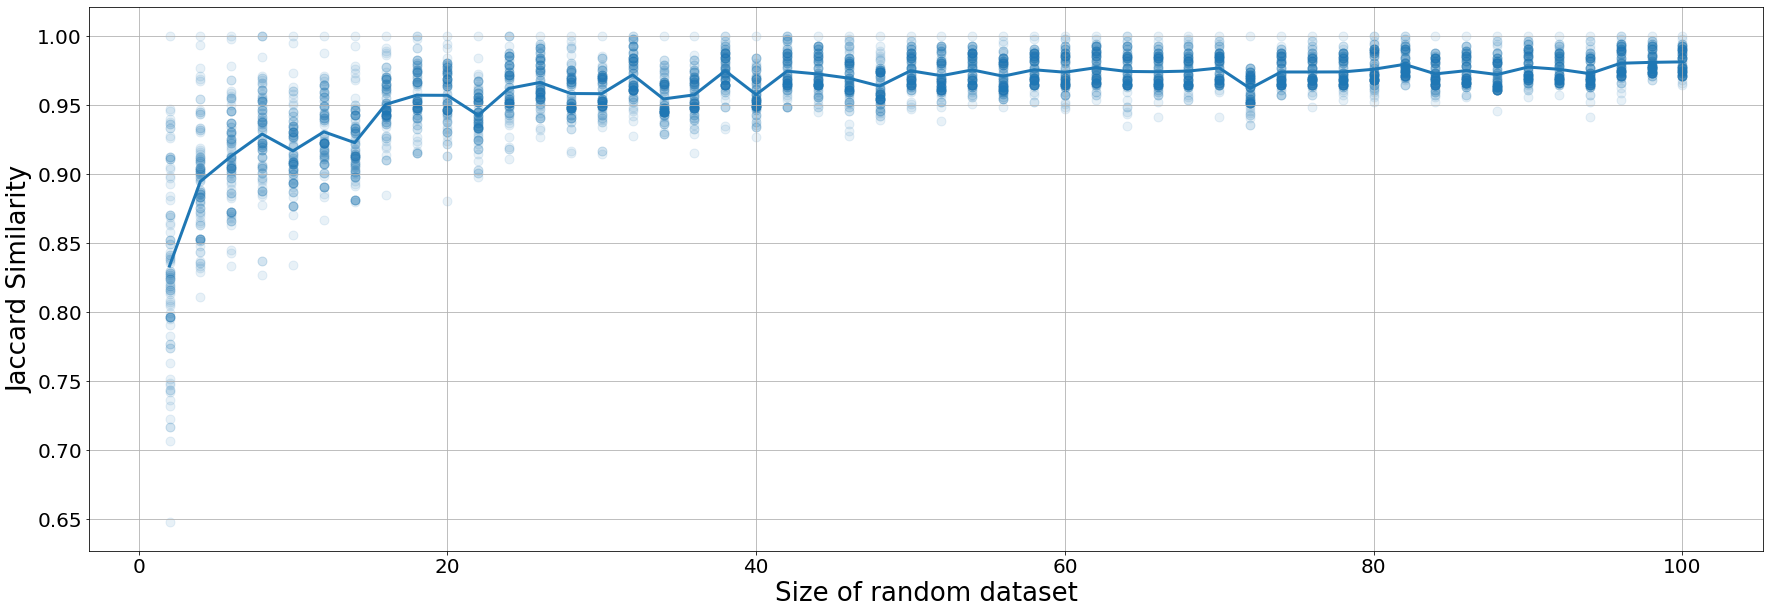

In [31]:
fig, ax = plt.subplots(figsize = (30, 10))

which = 4

print('REPLICATION PROBABILITY =',replic_prob[which])

#plt.plot(sample_sizes, mean_diff[which], linewidth = 3)
plt.plot(sample_sizes, jaccard[which].mean(axis = 1), linewidth = 3)

#for toplot in MSE[which].T:
for toplot in jaccard[which].T:
    plt.scatter(sample_sizes, toplot, color = 'tab:blue', alpha = 0.1, s = 80)

#plt.yticks(np.arange(0.0025, 0.03, 0.0025))
plt.xlabel('Size of random dataset', fontsize = 26)
plt.ylabel('Jaccard Similarity', fontsize = 26)

plt.tick_params(labelsize = 20)
    
#plt.axis([0, 102, 0, 0.02])
plt.grid()

#plt.savefig('The_Draft/n_randata')

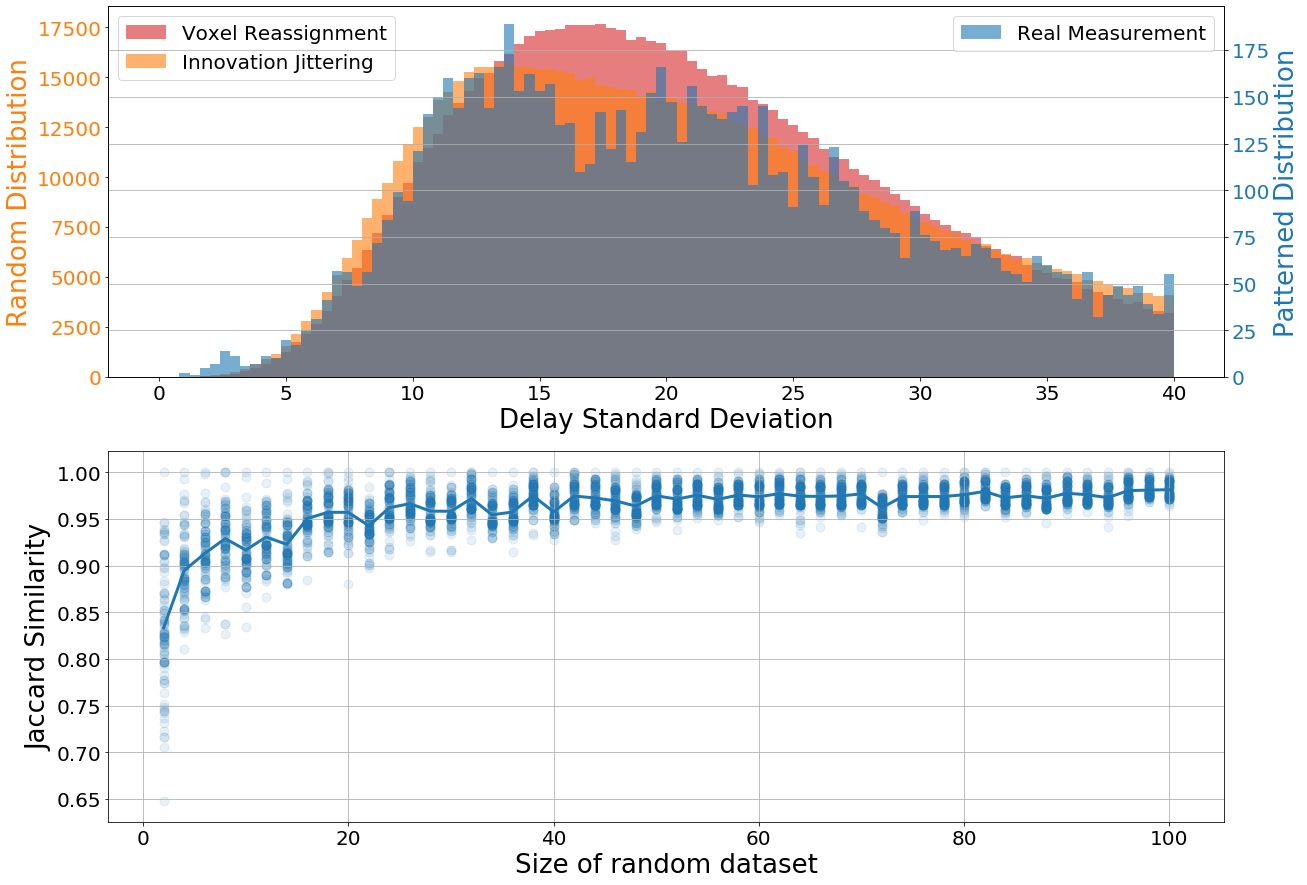

In [52]:
subj, reprob = 8, 4

fig, ax = plt.subplots(figsize = (20, 15))

ax = plt.subplot(2, 1, 1)

ax1, ax2 = plot_hist_2dist([dc_perm_nojit[subj, reprob], dc_perm_jit[subj, reprob]], dc_patt[subj, reprob],
                           ax = ax, n_bins = 100, maxrange = 40, alpha = 0.6)

ax1.tick_params(labelsize = 20)
ax2.tick_params(labelsize = 20)

plt.subplot(2, 1, 2)

which = 4

plt.plot(sample_sizes, jaccard[which].mean(axis = 1), linewidth = 3)

for toplot in jaccard[which].T:
    plt.scatter(sample_sizes, toplot, color = 'tab:blue', alpha = 0.1, s = 80)

plt.xlabel('Size of random dataset', fontsize = 26)
plt.ylabel('Jaccard Similarity', fontsize = 26)

plt.tick_params(labelsize = 20)

plt.grid()

plt.savefig('The_Draft/Valid')

REPLICATION PROBABILITY = 70
REPLICATION PROBABILITY = 75
REPLICATION PROBABILITY = 80
REPLICATION PROBABILITY = 85
REPLICATION PROBABILITY = 90
REPLICATION PROBABILITY = 95
REPLICATION PROBABILITY = 100


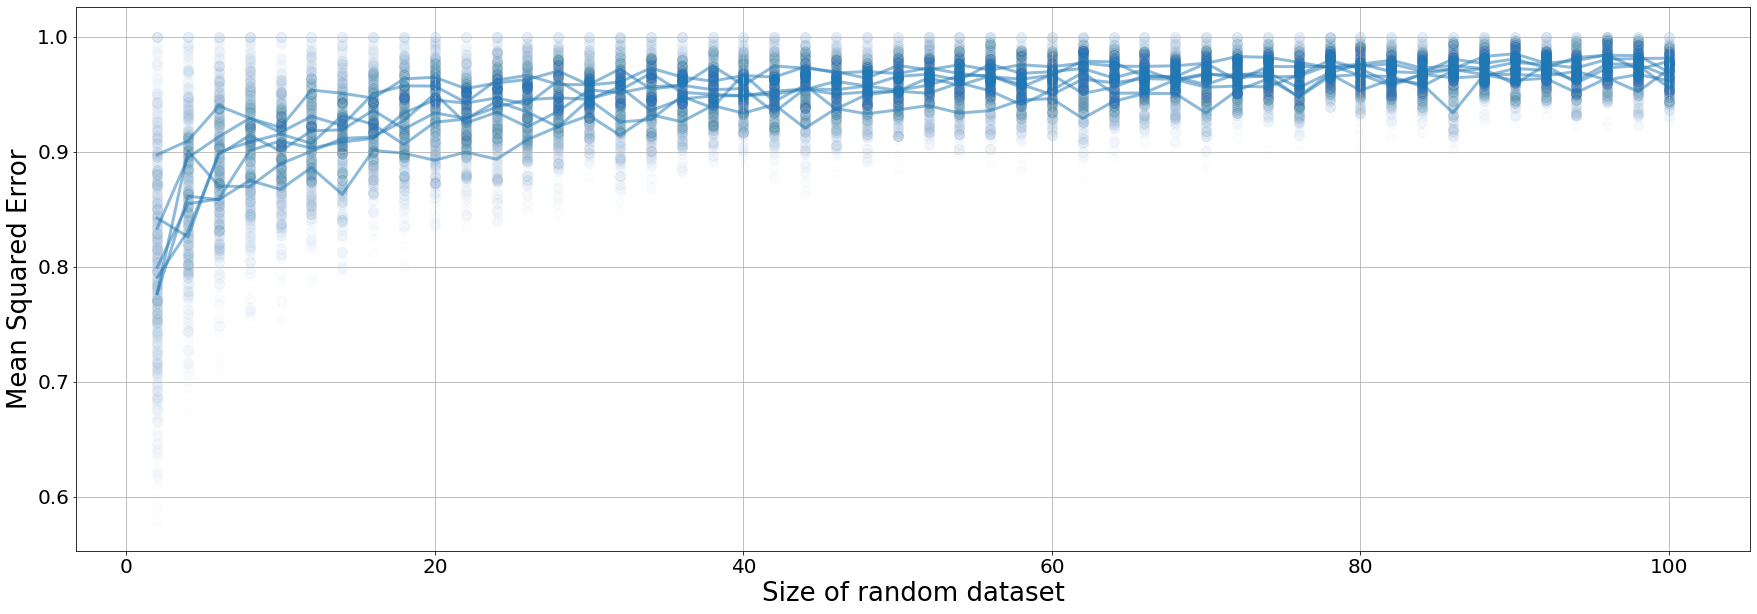

In [30]:
fig, ax = plt.subplots(figsize = (30, 10))

for which in range(7):
    print('REPLICATION PROBABILITY =',replic_prob[which])

    #plt.plot(sample_sizes, mean_diff[which], linewidth = 3, color = 'tab:blue', alpha = 0.5)
    plt.plot(sample_sizes, jaccard[which].mean(axis = 1), linewidth = 3, color = 'tab:blue',
             alpha = 0.5)

    #for toplot in MSE[which].T:
    for toplot in jaccard[which].T:
        plt.scatter(sample_sizes, toplot, color = 'tab:blue', alpha = 0.01, s = 100)

#plt.yticks(np.arange(0.0025, 0.03, 0.0025))
plt.xlabel('Size of random dataset', fontsize = 26)
plt.ylabel('Mean Squared Error', fontsize = 26)

plt.tick_params(labelsize = 20)

#plt.axis([0, 102, 0, 0.03])
plt.grid()